In [4]:
!pip install langchain_community
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.3 MB/s eta 0:00:00


In [5]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
# Set the API token
api_token = userdata.get('api_token')
os.environ["REPLICATE_API_TOKEN"] = api_token
# Model setup
model = "ibm-granite/granite-3.3-8b-instruct"
output = Replicate(model=model,replicate_api_token=api_token,)

In [6]:
import pandas as pd
import requests

# Fetch the data.
df = pd.read_csv("https://ourworldindata.org/grapher/renewable-share-energy.csv?v=1&csvType=full&useColumnShortNames=true", storage_options = {'User-Agent': 'Our World In Data data fetch/1.0'})

# Fetch the metadata
metadata = requests.get("https://ourworldindata.org/grapher/renewable-share-energy.metadata.json?v=1&csvType=full&useColumnShortNames=true").json()

In [7]:
# Show first few rows
df.head()

# Basic information about columns, types, and missing values
df.info()

# Check for missing values
df.isnull().sum()

# Get summary statistics
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6379 entries, 0 to 6378
Data columns (total 4 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Entity                                     6379 non-null   object 
 1   Code                                       4539 non-null   object 
 2   Year                                       6379 non-null   int64  
 3   renewables__pct_equivalent_primary_energy  6379 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 199.5+ KB


,Year,renewables__pct_equivalent_primary_energy
count,6379.000000,6379.000000
mean,1995.358207,11.118055
std,17.145077,13.269040
min,1965.000000,0.000000
25%,1981.000000,2.126912
50%,1996.000000,6.550673
75%,2010.000000,15.007385
max,2024.000000,86.126360


In [8]:
df.columns.tolist()

['Entity', 'Code', 'Year', 'renewables__pct_equivalent_primary_energy']

In [9]:
# Rename for readability
df.rename(columns={
    'renewables__pct_equivalent_primary_energy': 'Renewable_Share'
}, inplace=True)

# Drop rows without country code (non-country entries like 'World', 'Africa')
df = df.dropna(subset=['Code'])

# Drop remaining rows with missing Renewable_Share just in case
df.dropna(subset=['Renewable_Share'], inplace=True)

# Optional: Filter years >= 2010 for more recent trends
df = df[df['Year'] >= 2010]

# Pivot: Countries (rows) vs Years (columns)
df_pivot = df.pivot_table(index='Entity', columns='Year', values='Renewable_Share')

# Keep only countries with ≥5 valid years of data
df_pivot = df_pivot.dropna(thresh=5)

/tmp/ipython-input-9-2926980682.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(subset=['Renewable_Share'], inplace=True)


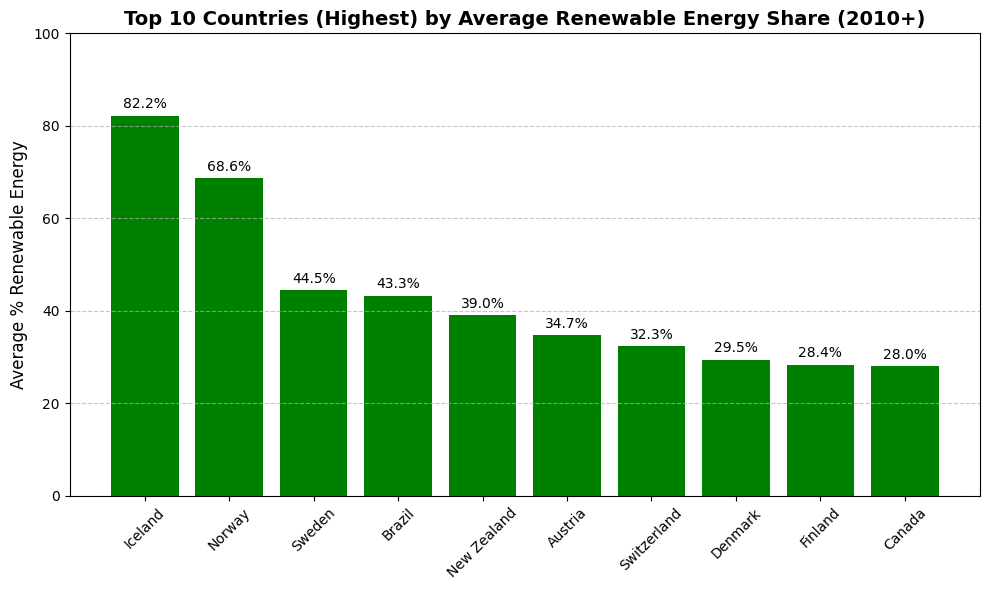

In [10]:
import matplotlib.pyplot as plt

# Plot: Top 10 countries with Highest average renewable share (2010+)
avg_renewable = df.groupby("Entity")["Renewable_Share"].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
bars = plt.bar(avg_renewable.index, avg_renewable.values, color='green')

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 1,
             f"{height:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Countries (Highest) by Average Renewable Energy Share (2010+)", fontsize=14, fontweight='bold')
plt.ylabel("Average % Renewable Energy", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 100)  # Adjust Y-axis for better spacing
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

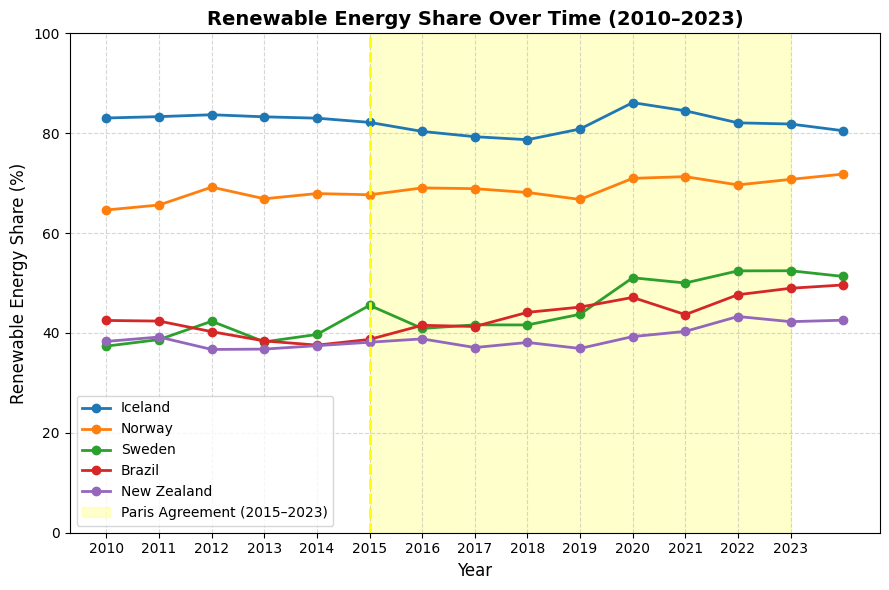

In [25]:
import matplotlib.pyplot as plt

# Step 1: Countries to plot (highest average renewable share)
countries_to_plot = ['Iceland', 'Norway', 'Sweden', 'Brazil', 'New Zealand']
colors = {
    'Iceland': '#1f77b4',        # Blue
    'Norway': '#ff7f0e',        # Orange
    'Sweden': '#2ca02c',        # Green
    'Brazil': '#d62728',   # Red
    'New Zealand': '#9467bd'        # Purple
}

# Filter dataset
df_filtered = df[df['Entity'].isin(countries_to_plot)]

# Step 2: Plot with markers and color
plt.figure(figsize=(9,6))
for country in countries_to_plot:
    country_data = df_filtered[df_filtered['Entity'] == country]

    plt.plot(
        country_data['Year'],
        country_data['Renewable_Share'],
        label=country,
        marker='o',
        color=colors[country],
        linewidth=2
    )

# Step 3: Highlight Paris Agreement period
plt.axvspan(2015, 2023, color='yellow', alpha=0.2, label='Paris Agreement (2015–2023)')
plt.axvline(x=2015, color='yellow', linestyle='--', linewidth=2)

# Show all years from 2010 to 2023
plt.xticks(range(2010, 2024), fontsize=10)

# Final formatting
plt.title("Renewable Energy Share Over Time (2010–2023)", fontsize=14, fontweight='bold')
plt.ylabel("Renewable Energy Share (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylim(0, 100)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Find bottom 10 countries by average renewable share (2010+)
lowest_renewable = df.groupby("Entity")["Renewable_Share"].mean().sort_values().head(10)
print(lowest_renewable)

Entity
Turkmenistan           0.005686
Trinidad and Tobago    0.007770
Kuwait                 0.034916
Saudi Arabia           0.097375
Qatar                  0.164679
Algeria                0.195752
Oman                   0.269629
Singapore              0.325264
Hong Kong              0.387470
Belarus                0.622906
Name: Renewable_Share, dtype: float64


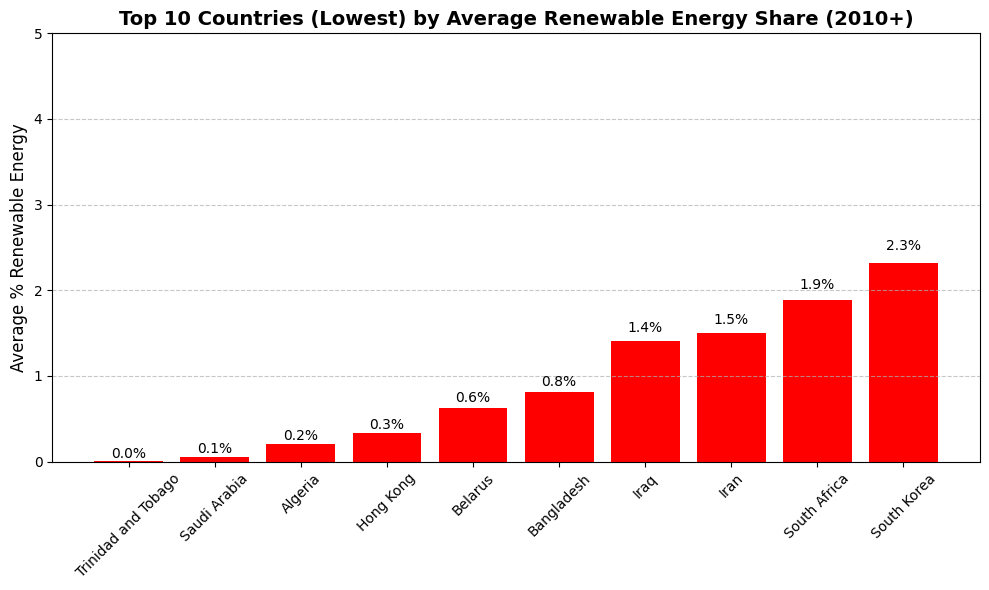

In [13]:
import matplotlib.pyplot as plt

# Plot: Top 10 countries with lowest average renewable share (2010+)
avg_renewable = df.groupby("Entity")["Renewable_Share"].mean().sort_values(ascending=True).head(10)

plt.figure(figsize=(10,6))
bars = plt.bar(avg_renewable.index, avg_renewable.values, color='red')

# Add data labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + (height * 0.05),
             f"{height:.1f}%", ha='center', va='bottom', fontsize=10)

plt.title("Top 10 Countries (Lowest) by Average Renewable Energy Share (2010+)", fontsize=14, fontweight='bold')
plt.ylabel("Average % Renewable Energy", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 5)  # Adjust Y-axis for better spacing
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

#plt.ylim(0, 5)  # Set Y-axis range to 0–100%

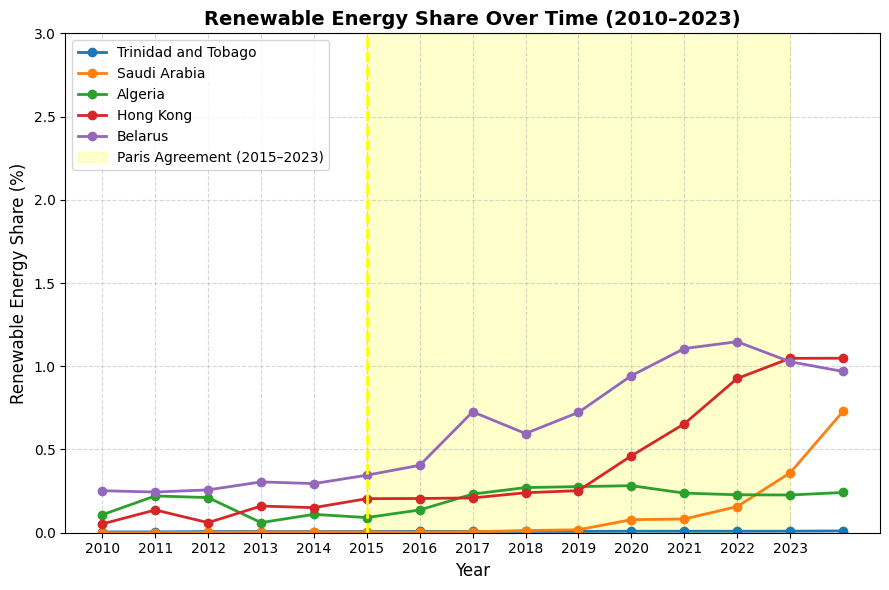

In [23]:
import matplotlib.pyplot as plt

# Step 1: Define countries and assign diverse colors
countries_to_plot = ['Trinidad and Tobago', 'Saudi Arabia', 'Algeria', 'Hong Kong', 'Belarus']
colors = {
    'Trinidad and Tobago': '#1f77b4',  # Blue
    'Saudi Arabia': '#ff7f0e',         # Orange
    'Algeria': '#2ca02c',              # Green
    'Hong Kong': '#d62728',            # Red
    'Belarus': '#9467bd'               # Purple
}

# Filter the data
df_filtered = df[df['Entity'].isin(countries_to_plot)]

# Step 2: Create time series with markers and consistent colors
plt.figure(figsize=(9,6))
for country in countries_to_plot:
    country_data = df_filtered[df_filtered['Entity'] == country]

    plt.plot(
        country_data['Year'],
        country_data['Renewable_Share'],
        label=country,
        marker='o',
        color=colors[country],
        linewidth=2
    )

# Step 3: Shaded policy period: Paris Agreement
plt.axvspan(2015, 2023, color='yellow', alpha=0.2, label='Paris Agreement (2015–2023)')
plt.axvline(x=2015, color='yellow', linestyle='--', linewidth=2)

# Final formatting
plt.title("Renewable Energy Share Over Time (2010–2023)", fontsize=14, fontweight='bold')
plt.ylabel("Renewable Energy Share (%)", fontsize=12)
plt.xlabel("Year", fontsize=12)
plt.ylim(0, 3)  # Focused scale for low performers
plt.xticks(range(2010, 2024), fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

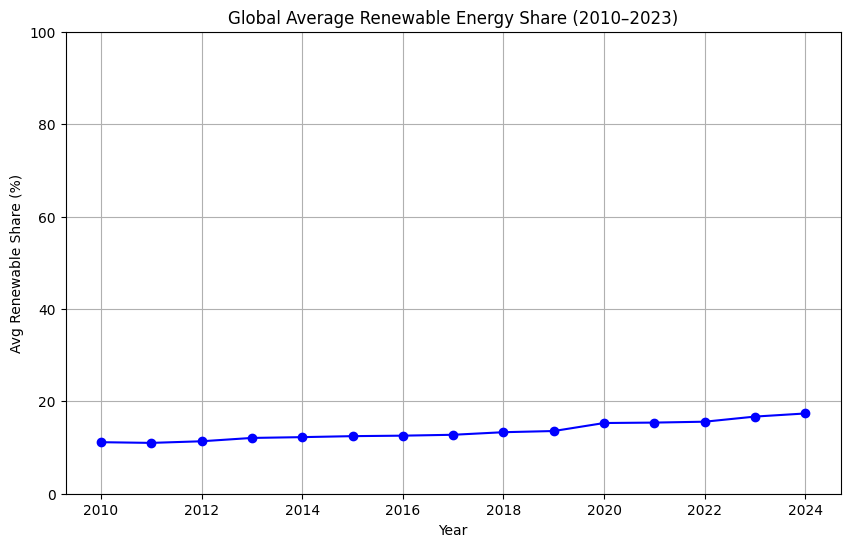

In [27]:
# Global yearly average
global_avg = df.groupby('Year')['Renewable_Share'].mean()

plt.figure(figsize=(10,6))
plt.plot(global_avg.index, global_avg.values, marker='o', color='blue')
plt.title("Global Average Renewable Energy Share (2010–2023)")
plt.xlabel("Year")
plt.ylabel("Avg Renewable Share (%)")
plt.ylim(0, 100)
plt.grid(True)
plt.show()

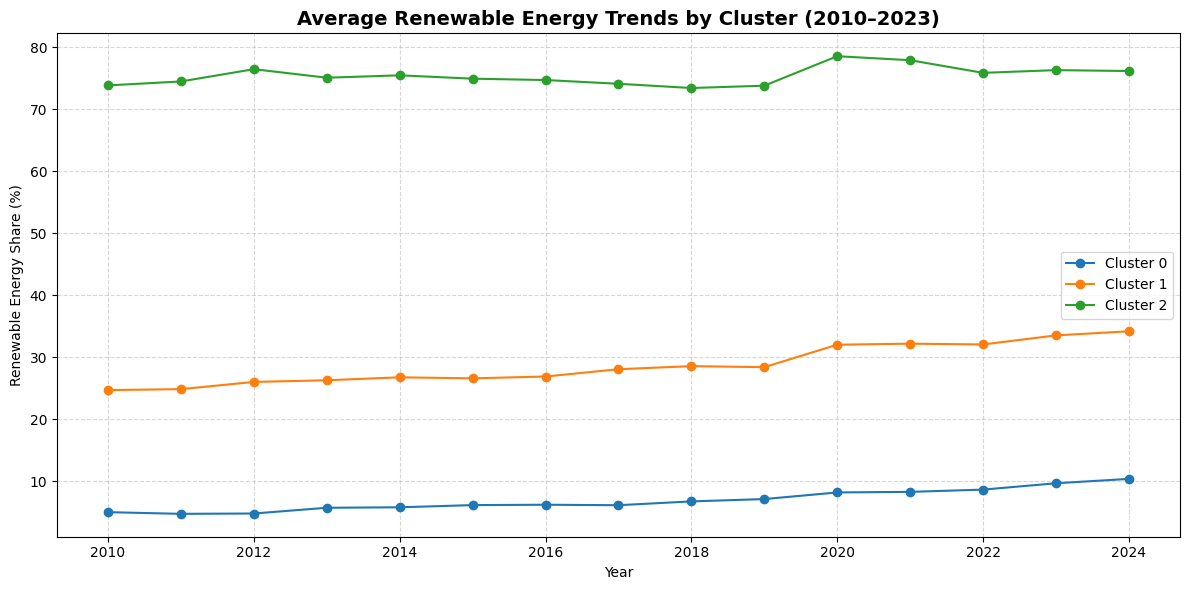

In [28]:
# Step 1: Pivot the dataset to wide format (countries × years)
df_pivot = df[df['Year'] >= 2010].pivot(index='Entity', columns='Year', values='Renewable_Share')
df_pivot = df_pivot.dropna()  # drop countries with missing years

# Step 2: Apply KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

# Step 3: Plot average trends for each cluster
df_pivot['Cluster'] = df_pivot['Cluster'].astype(str)
df_pivot_grouped = df_pivot.groupby('Cluster').mean().T  # Transpose to plot Year on X-axis

plt.figure(figsize=(12,6))
for cluster_label in df_pivot_grouped.columns:
    plt.plot(df_pivot_grouped.index, df_pivot_grouped[cluster_label], label=f"Cluster {cluster_label}", marker='o')

plt.title("Average Renewable Energy Trends by Cluster (2010–2023)", fontsize=14, fontweight='bold')
plt.ylabel("Renewable Energy Share (%)")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [29]:
df_pivot.reset_index()[['Entity', 'Cluster']].head(10)

Year,Entity,Cluster
0,Algeria,0
1,Argentina,0
2,Australia,0
3,Austria,1
4,Azerbaijan,0
5,Bangladesh,0
6,Belarus,0
7,Belgium,0
8,Brazil,1
9,Bulgaria,0


In [30]:
# Prepare the input prompt
prompt = """
I am analyzing a dataset of renewable energy share (%) across countries from 2010 to 2023.
The top 5 countries with the highest average share are:
1. Norway
2. Sweden
3. Brazil
4. New Zealand
5. Austria

The top 5 countries with the lowest adoption are:
- Trinidad and Tobago
- Saudi Arabia
- Algeria
- Hong Kong
- Belarus

Please provide insights on:
- Why some countries have higher renewable adoption
- Why some countries have lower renewable adoption
- Regional or economic patterns in the data
- Any trends visible over the decade
- Recommendations for low-adoption countries
"""

In [31]:
response = output.invoke(prompt)
print(response)

RuntimeError: Prediction failed for an unknown reason. It might have run out of memory? (exitcode -9)

In [32]:
# Reshape data: rows = countries, columns = years
df_pivot = df[df['Year'] >= 2010].pivot(index='Entity', columns='Year', values='Renewable_Share')
df_pivot = df_pivot.dropna()  # Remove countries with missing years

In [33]:
from sklearn.cluster import KMeans

# Apply KMeans to time series data
kmeans = KMeans(n_clusters=3, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

In [34]:
# Get country ISO codes for Plotly
country_codes = df[['Entity', 'Code']].drop_duplicates()
df_clustered = df_pivot.reset_index().merge(country_codes, left_on='Entity', right_on='Entity', how='left')

<Axes: title={'center': 'Average Renewable Share by Cluster'}>

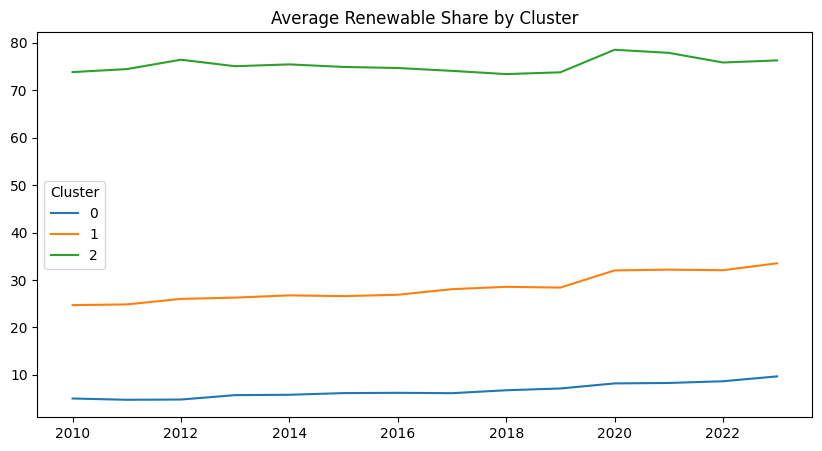

In [35]:
# Preview average renewable share per cluster
cluster_stats = df_clustered.groupby("Cluster")[list(range(2010, 2024))].mean()
cluster_stats.T.plot(figsize=(10,5), title="Average Renewable Share by Cluster")

In [36]:
# Assuming you matched the meaning:
cluster_label_map = {
    '0': 'High Renewable Users',
    '1': 'Moderate Adopters',
    '2': 'Low Renewable Users'
}

df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

In [37]:
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

In [28]:
prompt = """
You are an energy analyst. Summarize the clustering results from renewable energy share data (2010–2023)
"""

In [29]:
response = output.invoke(prompt)
print(response)

To summarize the clustering results from renewable energy share data from 2010 to 2023, we would first need to perform a clustering analysis on the dataset. Here's a hypothetical summary based on such an analysis, assuming we used K-means clustering with three clusters for illustrative purposes:

---

**Renewable Energy Share Clustering Summary (2010–2023)**

After applying K-means clustering to the annual renewable energy share data (2010–2023), we identified three distinct clusters that represent different patterns of renewable energy adoption across countries or regions.

**Cluster 1: Rapid Growth Leaders**

- **Characteristics**: This cluster consists of countries with the highest renewable energy shares, characterized by consistent, rapid growth over the period. These nations have aggressively pursued renewable energy policies, including feed-in tariffs, renewable portfolio standards, and significant investments in solar and wind capacities.
  
- **Key Players**: 
  - **Country A*

In [140]:
# Define refined prompt for IBM Granite summarization
refined_prompt = f"""
You are a renewable energy analyst.

Based on the clustering of countries by their renewable energy share trends from 2010 to 2023, we identified three groups:

1. High Renewable Users: Countries like Norway, Sweden, and Brazil that consistently maintain a high percentage of renewable energy usage.

2. Moderate Adopters: Countries such as China, India, and Germany showing steady improvement and moderate adoption over the years.

3. Low Renewable Users: Countries including Saudi Arabia, Trinidad and Tobago, and Hong Kong with persistently low or stagnant renewable energy shares.

For each group, summarize:
- Their general renewable energy trend over time
- Possible reasons behind their performance
- Policy or investment implications

Keep your explanation clear and concise for a non-technical audience. Limit to 3 paragraphs.
"""
response = output.invoke(prompt)
print(response)

To summarize the clustering results from renewable energy share data (2010–2023) as an energy analyst, I would follow these steps:

1. **Data Collection**: Gather renewable energy share data for various countries or regions from reliable sources like the International Energy Agency (IEA), International Renewable Energy Agency (IRENA), or national energy statistics offices. This data would typically include percentages of total energy consumption derived from sources like solar, wind, hydro, biomass, and geothermal.

2. **Data Preprocessing**: Clean the dataset by handling missing values, normalizing the data, and ensuring consistency in time intervals (annual or decadal averages).

3. **Feature Selection**: Choose relevant features for clustering. Besides the renewable energy share percentages, other features could include GDP per capita, energy consumption per capita, government policies on renewables, technological advancements, and geographical factors.

4. **Clustering Method Selec

In [38]:
# Check the centroids to determine meaning of each cluster
print(kmeans.cluster_centers_)


[[ 5.00312176  4.73345712  4.78655505  5.71251577  5.79002197  6.14231211
   6.20161748  6.12509808  6.74012329  7.1170061   8.18377801  8.27815325
   8.64165061  9.66628443 10.37136409]
 [24.69468428 24.84496606 26.00922511 26.27812172 26.75361478 26.58908878
  26.88371428 28.05739556 28.55593039 28.39103056 32.01181194 32.17992333
  32.05406472 33.51655122 34.18126994]
 [73.83824    74.471755   76.450596   75.0772705  75.46305    74.92202
  74.701605   74.09877    73.41559    73.792235   78.544633   77.899873
  75.86187    76.3006275  76.15503   ]]


In [40]:
# Calculate average renewable share per country
df_clustered['Average_Renewable_Share'] = df_clustered[list(range(2010, 2024))].mean(axis=1)

# Calculate mean renewable share per cluster
cluster_means = df_clustered.groupby('Cluster')['Average_Renewable_Share'].mean().sort_values(ascending=False)

# Create a mapping from old cluster to new label (High=0, Moderate=1, Low=2)
cluster_order = {old: new for new, old in enumerate(cluster_means.index)}

# Remap cluster numbers
df_clustered['Cluster_Ordered'] = df_clustered['Cluster'].map(cluster_order)

# Map new labels for visualization
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}
df_clustered['Cluster_Label'] = df_clustered['Cluster_Ordered'].map(cluster_label_map)

In [41]:
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

In [42]:
# Analyze characteristics of each cluster
cluster_analysis = df_clustered.groupby('Cluster_Label')['Average_Renewable_Share'].agg(['mean', 'median', 'min', 'max', 'std']).reset_index()
display(cluster_analysis)

# Get a list of countries in each cluster
for cluster_label in df_clustered['Cluster_Label'].unique():
    countries_in_cluster = df_clustered[df_clustered['Cluster_Label'] == cluster_label]['Entity'].tolist()
    print(f"Countries in {cluster_label}: {countries_in_cluster}")

,Cluster_Label,mean,median,min,max,std
0,0 = High Renewable Users,6.651550,6.398945,0.005616,17.247452,5.180228
1,1 = Moderate Adopters,28.344294,27.309135,18.697987,43.978110,7.367349
2,2 = Low Renewable Users,75.345581,75.345581,68.386237,82.304925,9.841999


Countries in 0 = High Renewable Users: ['Algeria', 'Argentina', 'Australia', 'Azerbaijan', 'Bangladesh', 'Belarus', 'Belgium', 'Bulgaria', 'China', 'Cyprus', 'Czechia', 'Egypt', 'Estonia', 'France', 'Germany', 'Greece', 'Hong Kong', 'Hungary', 'India', 'Indonesia', 'Iran', 'Iraq', 'Ireland', 'Israel', 'Italy', 'Japan', 'Kazakhstan', 'Kuwait', 'Lithuania', 'Luxembourg', 'Malaysia', 'Mexico', 'Morocco', 'Netherlands', 'North Macedonia', 'Oman', 'Pakistan', 'Philippines', 'Poland', 'Qatar', 'Romania', 'Russia', 'Saudi Arabia', 'Singapore', 'Slovakia', 'Slovenia', 'South Africa', 'South Korea', 'Sri Lanka', 'Taiwan', 'Thailand', 'Trinidad and Tobago', 'Turkey', 'Turkmenistan', 'Ukraine', 'United Arab Emirates', 'United Kingdom', 'United States', 'Uzbekistan', 'World']
Countries in 1 = Moderate Adopters: ['Austria', 'Brazil', 'Canada', 'Chile', 'Colombia', 'Croatia', 'Denmark', 'Ecuador', 'Finland', 'Latvia', 'New Zealand', 'Peru', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'Venezuela', 

In [44]:
# Define refined prompt for IBM Granite summarization
refined_prompt = f"""
You are a renewable energy analyst.

Based on the clustering of countries by their renewable energy share trends from 2010 to 2023, we identified three groups:

1. {df_clustered[df_clustered['Cluster_Ordered'] == 0]['Cluster_Label'].iloc[0]}: These countries consistently maintain a high percentage of renewable energy usage.

2. {df_clustered[df_clustered['Cluster_Ordered'] == 1]['Cluster_Label'].iloc[0]}: These countries show steady improvement and moderate adoption over the years.

3. {df_clustered[df_clustered['Cluster_Ordered'] == 2]['Cluster_Label'].iloc[0]}: These countries have persistently low or stagnant renewable energy shares.

Here are some statistics for each cluster:
{cluster_analysis.to_string()}

Here are some example countries in each cluster:
{df_clustered.groupby('Cluster_Label')['Entity'].apply(lambda x: x.sample(min(5, len(x)), random_state=42).tolist()).to_string()}

For each group, summarize:
- Their general renewable energy trend over time
- Possible reasons behind their performance
- Policy or investment implications

Keep your explanation clear and concise for a non-technical audience. Limit to 3 paragraphs.
"""
response = output.invoke(prompt)
print(response)

### Insights on Renewable Energy Adoption

#### High Renewable Adoption Countries:

1. **Norway**: 
   - **Geography and Resources**: Norway benefits from abundant hydropower resources. The country generates over 95% of its electricity from hydropower. Its cold climate also favors energy efficiency.
   - **Policy and Infrastructure**: Strong government support for renewables, including subsidies and regulatory frameworks, has encouraged investment in renewable technologies.
   - **Economic Structure**: A robust economy with high public investment in green technologies and a commitment to carbon neutrality by 2030.

2. **Sweden**:
   - **Hydropower and Biomass**: Similar to Norway, Sweden leverages hydropower and biomass, with significant investments in wind energy.
   - **Policy Focus**: Long-term energy policies emphasizing renewable energy targets and carbon neutrality by 2045.
   - **Public Support**: High public acceptance of renewable energy initiatives, including community-based 

<Axes: title={'center': 'Average Renewable Share by Cluster (Sorted)'}>

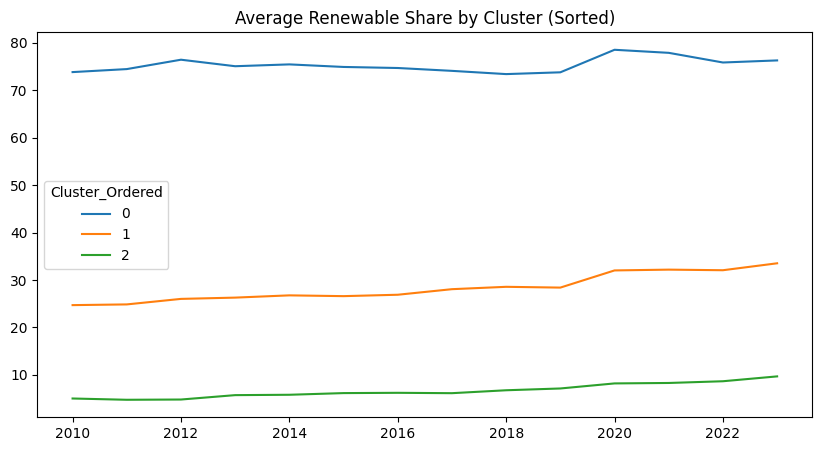

In [45]:
# Step 1: Reshape the data
df_pivot = df[df['Year'] >= 2010].pivot(index='Entity', columns='Year', values='Renewable_Share')
df_pivot = df_pivot.dropna()  # Drop countries with missing data

# Step 2: Apply KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

# Step 3: Add ISO country codes for Plotly choropleth
country_codes = df[['Entity', 'Code']].drop_duplicates()
df_clustered = df_pivot.reset_index().merge(country_codes, on='Entity', how='left')

# Step 4: Determine cluster order based on average renewable share
df_clustered['Avg_Share'] = df_clustered[list(range(2010, 2024))].mean(axis=1)
cluster_order = (
    df_clustered.groupby('Cluster')['Avg_Share']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Create a mapping: original cluster → ordered cluster
cluster_map = {row['Cluster']: i for i, row in cluster_order.iterrows()}
df_clustered['Cluster_Ordered'] = df_clustered['Cluster'].map(cluster_map)

# Step 5: Assign human-readable labels
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}
df_clustered['Cluster_Label'] = df_clustered['Cluster_Ordered'].map(cluster_label_map)

# Optional: plot cluster trends
cluster_stats = df_clustered.groupby("Cluster_Ordered")[list(range(2010, 2024))].mean()
cluster_stats.T.plot(figsize=(10,5), title="Average Renewable Share by Cluster (Sorted)")

In [2]:
!pip install -q kaleido

In [8]:
from sklearn.cluster import KMeans

# 1. Pivot the data and drop missing values
df_pivot = df[df['Year'] >= 2010].pivot(index='Entity', columns='Year', values='Renewable_Share')
df_pivot = df_pivot.dropna()

# 2. Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

# 3. Map cluster number to average renewable share
cluster_means = df_pivot.groupby('Cluster').mean().mean(axis=1).sort_values(ascending=False)
cluster_map = {cluster: i for i, cluster in enumerate(cluster_means.index)}

# 4. Reassign cluster labels based on average rank (0=High, 1=Moderate, 2=Low)
df_pivot['Cluster'] = df_pivot['Cluster'].map(cluster_map)

# 5. Add country codes back for choropleth
country_codes = df[['Entity', 'Code']].drop_duplicates()
df_clustered = df_pivot.reset_index().merge(country_codes, on='Entity', how='left')

# 6. Map final labels
cluster_label_map = {
    0: 'High Renewable Users',
    1: 'Moderate Adopters',
    2: 'Low Renewable Users'
}
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

In [9]:
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

In [10]:
# Fill missing values with interpolation or forward fill
df_pivot = df[df['Year'] >= 2010].pivot(index='Entity', columns='Year', values='Renewable_Share')
df_pivot = df_pivot.interpolate(axis=1).ffill(axis=1).bfill(axis=1)  # Fills missing values

# Optional: drop rows with too many NaNs if needed
df_pivot = df_pivot.dropna(thresh=10)  # Only keep countries with at least 10 valid years

In [11]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df_pivot['Cluster'] = kmeans.fit_predict(df_pivot)

# Remap clusters based on average renewable share
cluster_means = df_pivot.groupby('Cluster').mean().mean(axis=1).sort_values(ascending=False)
cluster_map = {cluster: i for i, cluster in enumerate(cluster_means.index)}
df_pivot['Cluster'] = df_pivot['Cluster'].map(cluster_map)

# Add ISO country codes back
df_clustered = df_pivot.reset_index().merge(df[['Entity', 'Code']].drop_duplicates(), on='Entity', how='left')

# Assign readable labels
cluster_label_map = {
    0: 'High Renewable Users',
    1: 'Moderate Adopters',
    2: 'Low Renewable Users'
}
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

In [16]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

# Define refined prompt for IBM Granite summarization
refined_prompt = f"""
You are a renewable energy analyst.

Based on the clustering of countries by their renewable energy share trends from 2010 to 2023, we identified three groups:

1. Cluster 0 : These countries consistently maintain a high percentage of renewable energy usage.

2. Cluster 1 : These countries show steady improvement and moderate adoption over the years.

3. Cluster 2 : These countries have persistently low or stagnant renewable energy shares.

For each group, summarize:
- Their general renewable energy trend over time
- Possible reasons behind their performance
- Policy or investment implications

Keep your explanation clear and concise for a non-technical audience. Limit to 3 paragraphs.
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt)
# Print the response
print("Granite Model Refined Response:\n")
print(response)

ImportError: Could not import replicate python package. Please install it with `pip install replicate`.

In [19]:
!pip install -q kaleido
!pip install -U kaleido

In [5]:
!pip install langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.3 MB/s eta 0:00:00


In [ ]:
# Define refined prompt for IBM Granite summarization
refined_prompt = f"""
You are a renewable energy analyst.

Based on the clustering of countries by their renewable energy share trends from 2010 to 2023, we identified three groups:

1. Cluster 0 : These countries consistently maintain a high percentage of renewable energy usage.

2. Cluster 1 : These countries show steady improvement and moderate adoption over the years.

3. Cluster 2 : These countries have persistently low or stagnant renewable energy shares.

For each group, summarize:
- Their general renewable energy trend over time
- Possible reasons behind their performance
- Policy or investment implications

Keep your explanation clear and concise for a non-technical audience. Limit to 3 paragraphs.
"""
response = output.invoke(prompt)
print(response)

In [17]:
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 1.9 MB/s eta 0:00:00


In [25]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

# Define refined prompt for IBM Granite summarization
prompt = """
Summarize the clustering groups based on renewable energy trends (2010–2023)
"""

# Invoke the model with the example prompt
response = output.invoke(prompt)
print(response)

From 2010 to 2023, renewable energy trends have been categorized into several key clustering groups based on technology, deployment, and policy trends:

1. **Technological Advancements**:
   - **Solar Photovoltaic (PV)**: The cost of solar PV modules dropped dramatically, leading to exponential growth in installations, especially in residential and utility-scale projects.
   - **Wind Energy**: Onshore and offshore wind technologies improved significantly in efficiency, with larger turbines and floating wind farms emerging.
   - **Energy Storage**: Battery storage technology, particularly lithium-ion, became more cost-effective and widely adopted to manage intermittency issues associated with solar and wind.
   - **Hydropower and Geothermal**: Continued development in these sectors, with innovations in small-scale and enhanced geothermal systems.

2. **Deployment Patterns**:
   - **Decentralization**: Increased adoption of distributed generation, with rooftop solar and small-scale wind 

In [22]:
from langchain_community.llms import Replicate
import os
from google.colab import userdata
import plotly.express as px

# Corrected dictionary with integer keys
cluster_label_map = {
    0: '0 = High Renewable Users',
    1: '1 = Moderate Adopters',
    2: '2 = Low Renewable Users'
}

# Apply mapping
df_clustered['Cluster_Label'] = df_clustered['Cluster'].map(cluster_label_map)

# Set color palette
custom_colors = px.colors.qualitative.Set1[:3]

# Plot
fig = px.choropleth(
    df_clustered,
    locations="Code",
    color="Cluster_Label",
    hover_name="Entity",
    color_discrete_sequence=custom_colors,
    title="Country Groups Based on Renewable Energy Trends (2010–2023)",
    projection="natural earth"
)

fig.update_layout(
    legend_title_text="Cluster Definition",
    geo=dict(showframe=False, showcoastlines=True)
)

fig.show()

# Define refined prompt for IBM Granite summarization
refined_prompt = f"""
You are a renewable energy analyst.

Based on the clustering of countries by their renewable energy share trends from 2010 to 2023, we identified three groups:

1. Cluster 0 : These countries consistently maintain a high percentage of renewable energy usage.

2. Cluster 1 : These countries show steady improvement and moderate adoption over the years.

3. Cluster 2 : These countries have persistently low or stagnant renewable energy shares.

For each group, summarize:
- Their general renewable energy trend over time
- Possible reasons behind their performance
- Policy or investment implications

Keep your explanation clear and concise for a non-technical audience. Limit to 3 paragraphs.
"""
# Invoke the model with the example prompt
response = output.invoke(refined_prompt)
# Print the response
print("Granite Model Refined Response:\n")
print(response)

Granite Model Refined Response:

Cluster 0, comprising countries with consistently high renewable energy usage, demonstrates a stable upward trend, reflecting their strong commitment to clean energy. These nations often possess robust policy frameworks that incentivize renewable energy adoption, such as feed-in tariffs or renewable portfolio standards. Abundant natural resources, like geothermal activity in Iceland or vast wind potential in Denmark, also contribute to their success. Policy implications for other countries might include implementing supportive regulations and investing in research to harness local renewable resources effectively.

Cluster 1 countries show steady improvement in renewable energy adoption, suggesting successful implementation of gradual policy changes and increasing investor confidence. Factors like declining technology costs, international climate commitments, and public support for clean energy initiatives likely drive their progress. Investment implicat